# Sample-specific mode (multi sample)

### Run Splitpea on SE counts to compare a set of samples versus a collection of background samples

Example workflow showing how to run Splitpea on an a set of cancer sample comparing with a set of normal tissue samples, leveraging the package's integration with the [IRIS data set](https://www.pnas.org/doi/10.1073/pnas.2221116120). This mode can be used to reproduce the analyses done in the [2024 Splitpea paper](https://pubmed.ncbi.nlm.nih.gov/38160308/). 



In [ ]:
%%capture
# install necessary dependencies (this can take a few minutes)
%pip install splitpea

# Tabix is used under-the-hood for some of the functions and should be installed before running
# install directly via the command line or with conda
#!sudo apt-get install tabix
%conda install -y -c bioconda tabix

In [1]:
# if all dependencies are installed begin right away
import splitpea

# additional imports for other downstream functions
import networkx as nx
import logging
import os
from concurrent.futures import ProcessPoolExecutor, as_completed

### Download/importing data from the IRIS collection

We’ll fetch the Uterine Carcinoma splicing data from [IRIS](https://github.com/Xinglab/IRIS) which contains the samples we want to compare against. You can also grab a normal background matrix for Uterus from this same collection, but we will instead use `splitpea.preprocess_pooled`'s `background` parameter, which can auto-download GTEx tissue matrices from IRIS.

In [3]:

!wget https://xinglabtrackhub.research.chop.edu/iris/IRIS_data.v2.0.0/db/TCGA_UCS_T/splicing_matrix/splicing_matrix.SE.cov10.TCGA_UCS_T.txt

# normal tissue samples
#!wget -q https://xinglabtrackhub.research.chop.edu/iris/IRIS_data.v2.0.0/db/GTEx_Uterus/splicing_matrix/splicing_matrix.SE.cov10.GTEx_Uterus.txt 

--2025-09-11 02:14:54--  https://xinglabtrackhub.research.chop.edu/iris/IRIS_data.v2.0.0/db/TCGA_UCS_T/splicing_matrix/splicing_matrix.SE.cov10.TCGA_UCS_T.txt
Resolving xinglabtrackhub.research.chop.edu (xinglabtrackhub.research.chop.edu)... 159.14.197.33
Connecting to xinglabtrackhub.research.chop.edu (xinglabtrackhub.research.chop.edu)|159.14.197.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43681277 (42M) [text/plain]
Saving to: ‘splicing_matrix.SE.cov10.TCGA_UCS_T.txt’

splicing_matrix.SE. 100%[===================>]  41.66M  11.2MB/s    in 4.5s    

2025-09-11 02:15:00 (9.21 MB/s) - ‘splicing_matrix.SE.cov10.TCGA_UCS_T.txt’ saved [43681277/43681277]



### Assembling the background set of samples

This function builds the inputs (`<sample>-psi.txt`) need to run Splitpea's sample-specific mode, and saves them to a specified output directory (`out_psi_dir`). This preprocessing step averages exon-level splicing data across a background set of samples, then computes ΔPSI and empirical p-values for other sample to compare against (`compare_path`).

Two options are available for generating these outputs: using a normal GTEx background data which can be automatically downloaded, or by supplying your own local background set of samples. For simiplicity, we show how to use the `background` parameter to automatically download normal tissue data from IRIS. In this case since we are studying Uterine Cancer we choose to download normal uterus samples. Alternatively we could choose from any background tissue in this set:  

> AdiposeTissue, AdrenalGland, Bladder, Blood, BloodVessel, Brain, Breast, CervixUteri, Colon, Esophagus, FallopianTube, Heart, Kidney, Liver, Lung, Muscle, Nerve, Ovary, Pancreas, Pituitary, Prostate, SalivaryGland, Skin, SmallIntestine, Spleen, Stomach, Testis, Thyroid, Uterus, and Vagina.

In [ ]:
# auto download GTEx tissue background from IRIS
# this compares every sample in the splicing matrix with the background
# takes approximately 10-30 minutes to complete depending on your
# computing resources
splitpea.preprocess_pooled(
    compare_path="splicing_matrix.SE.cov10.TCGA_UCS_T.txt",
    background="uterus",
    background_download_root="IRIS_uterus",
    out_psi_dir="UCS_PSI"
)

processing file: splicing_matrix.SE.cov10.GTEx_Uterus.txt
Starting delta PSI calculation...
Processing sample TCGA-N5-A4RM-01A-11R-A28V-07.aln...
Processing sample TCGA-N5-A4RF-01A-11R-A28V-07.aln...
Processing sample TCGA-N5-A4RU-01A-31R-A28V-07.aln...
Processing sample TCGA-NA-A4QY-01A-11R-A28V-07.aln...
Processing sample TCGA-NF-A5CP-01A-12R-A28V-07.aln...
Processing sample TCGA-ND-A4W6-01A-11R-A28V-07.aln...
Processing sample TCGA-QM-A5NM-01A-11R-A28V-07.aln...
Processing sample TCGA-NG-A4VW-01A-11R-A28V-07.aln...
Processing sample TCGA-N6-A4VE-01A-11R-A28V-07.aln...
Processing sample TCGA-NA-A5I1-01A-21R-A28V-07.aln...
Processing sample TCGA-N5-A4RS-01A-11R-A28V-07.aln...
Processing sample TCGA-N5-A4RO-01A-11R-A28V-07.aln...
Processing sample TCGA-N6-A4VG-01A-31R-A28V-07.aln...
Processing sample TCGA-NA-A4QV-01A-11R-A28V-07.aln...
Processing sample TCGA-NA-A4QX-01A-11R-A28V-07.aln...
Processing sample TCGA-N5-A4RJ-01A-11R-A28V-07.aln...
Processing sample TCGA-N5-A4RN-01A-12R-A28V-

'UCS_PSI'

If using your own background data point to a directory of similarly formatted samples. Uncomment the code below and update the paths to do this. Here, we show the sample format needed for these background files by displaying the Uterus splicing matrix we downloaded from IRIS.

The general structure is a tab-delimited file with the columns: `GeneID`, `geneSymbol`, `chromosome`, `strand`, `exonStart`, `exonEnd`, `upstreamEE`, `downstreamEE`, followed one column per sample with SE count values. In the case where there is no SE event please fill in `NaN`.

Generally, we do not recommend this method for running Splitpea unless you have more than 30 samples for the background. If you have a smaller sample set then we recommend running Splitpea in condition-specific mode.

In [ ]:
#splitpea.preprocess_pooled(
#    compare_path="splicing_matrix.SE.cov10.TCGA_UCS_T.txt",
#    background_path="<path_to_your_SE_background_data>.txt",
#    out_psi_dir="UCS_PSI"
#)
!head -n 10 IRIS_uterus/GTEx_Uterus/splicing_matrix/splicing_matrix.SE.cov10.GTEx_Uterus.txt

GeneID	geneSymbol	chr	strand	exonStart_0base	exonEnd	upstreamEE	downstreamES	SRR1069466	SRR1071737	SRR1073483	SRR1074430	SRR1075850	SRR1077211	SRR1078114	SRR1077159	SRR1077996	SRR1078188	SRR1078212	SRR1079874	SRR1079213	SRR1080342	SRR1082128	SRR1084553	SRR1085358	SRR1086369	SRR1094097	SRR1097929	SRR1096315	SRR1095261	SRR1096198	SRR1099857	SRR1100941	SRR1105130	SRR1105106	SRR1309745	SRR1121009	SRR1313991	SRR1319242	SRR1319991	SRR1321720	SRR1323234	SRR1329423	SRR1330082	SRR1336682	SRR1339258	SRR1338468	SRR1343943	SRR1353686	SRR1358126	SRR1360280	SRR1361138	SRR1363718	SRR1361838	SRR1374543	SRR1381372	SRR1383237	SRR1382780	SRR1387132	SRR1393004	SRR1389454	SRR1388257	SRR1394428	SRR1395874	SRR1419039	SRR1431104	SRR1433989	SRR1434070	SRR1442213	SRR1447281	SRR1445550	SRR1447192	SRR1452674	SRR1458828	SRR1458401	SRR1459147	SRR1468226	SRR1471395	SRR1475086	SRR1474208	SRR1475466	SRR1479826	SRR1473482	SRR1479450	SRR1486215	SRR1485848	SRR1489007	SRR1498726	SRR5125493	SRR1498747	SRR5125492	SRR1499584

### Running sample-specific mode with parallelization

Now that we have pre-calculated our splicing changes we can feed each sample into splitpea to produce one network per Uterine Carcinoma sample. This enables us to compare the rewiring changes across patients.

To speed up the computation time we run splitpea in parallel, update the `max_workers` parameter as your computing environment allows for improved computation times. Generally, each network is computed in minutes, and with the Uterine Carcinoma data set we have 57 patient networks to build.

We also include another code snippet for running without parallelization following this one.

In [ ]:
max_workers = 5
input_dir = "UCS_PSI/"
output_dir = "ucs_rewired_networks/"
verbose = False

if verbose:
  logging.basicConfig(level=logging.INFO, force=True)
else:
  logging.basicConfig(level=logging.WARNING, force=True)


os.makedirs(output_dir, exist_ok=True)

def run_one(input_file: str, output_prefix: str) -> str:
    import splitpea
    splitpea.run(input_file, output_prefix)
    return output_prefix

jobs = []
for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        ipref = filename.replace("-psi.txt", "")
        input_file = os.path.join(input_dir, filename)
        output_prefix = os.path.join(output_dir, ipref)
        jobs.append((input_file, output_prefix))

print(f"Submitting {len(jobs)} jobs with up to {max_workers} workers...")

futures = {}
with ProcessPoolExecutor(max_workers=max_workers) as ex:
    for inp, out in jobs:
        futures[ex.submit(run_one, inp, out)] = (inp, out)

    for fut in as_completed(futures):
        inp, out = futures[fut]
        try:
            fut.result()
            print(f"Done: {inp} -> {out}")
        except Exception as e:
            print(f"Failed: {inp} -> {out} ({e})")


Submitting 57 jobs with up to 50 workers...
Done: UCS_PSI/TCGA-ND-A4W6-01A-11R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-ND-A4W6-01A-11R-A28V-07.aln
Done: UCS_PSI/TCGA-N5-A4RF-01A-11R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-N5-A4RF-01A-11R-A28V-07.aln
Done: UCS_PSI/TCGA-N5-A4RM-01A-11R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-N5-A4RM-01A-11R-A28V-07.aln
Done: UCS_PSI/TCGA-N5-A4RJ-01A-11R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-N5-A4RJ-01A-11R-A28V-07.aln
Done: UCS_PSI/TCGA-N8-A4PM-01A-11R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-N8-A4PM-01A-11R-A28V-07.aln
Done: UCS_PSI/TCGA-N5-A4RS-01A-11R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-N5-A4RS-01A-11R-A28V-07.aln
Done: UCS_PSI/TCGA-N7-A4Y0-01A-12R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-N7-A4Y0-01A-12R-A28V-07.aln
Done: UCS_PSI/TCGA-N9-A4Q7-01A-11R-A28V-07.aln-psi.txt -> ucs_rewired_networks/TCGA-N9-A4Q7-01A-11R-A28V-07.aln
Done: UCS_PSI/TCGA-N5-A59E-01A-11R-A28V-07.aln-psi.txt -> uc

<details>
<summary><strong>Sequential run alternative - code snippet</strong></summary>

```python
data_dir = "UCS_PSI/"
output_dir = "ucs_rewired_networks/"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(data_dir):
    if filename.endswith("-psi.txt") or filename.endswith(".txt"):
        ipref = filename.replace("-psi.txt", "").replace(".txt","")
        input_file = os.path.join(data_dir, filename)
        output_prefix = os.path.join(output_dir, ipref)
        print(f"Running splitpea on {input_file} -> {output_prefix}")
        splitpea.run(input_file, output_prefix)
```
</details>

### Consensus network analysis
#### Creating summary networks to understand broad splicing dynamics in Uterine Carcinoma

The Splitpea runs above generate one rewired network per cancer sample in the original splicing matrix. While these are interesting on their own, we can also analyze the splicing changes across uterine cancer patients finding changes that are conserved or patient-specific. One way to do this is to combine all cancer patient networks into a "consensus" network that capture the edges shared across all patient rewired networks.

Using the function `splitpea.get_consensus_network` we build two summary networks: one for capturing shared loss-of-function (`consensus_network_neg.pickle`) and one for conserved gain-of-function edges (`consensus_network_pos.pickle`). These functions can be used with any directory of rewired networks to produce consensus summaries.

In [ ]:
cons_neg, cons_pos = splitpea.get_consensus_network("ucs_rewired_networks/") # pass in the path to the folder of rewired networks

[17:52:02] Loading networks...
[17:52:02] Adding ucs_rewired_networks/TCGA-N5-A4RS-01A-11R-A28V-07.aln.edges.pickle....
[17:52:02] Adding ucs_rewired_networks/TCGA-N5-A4RM-01A-11R-A28V-07.aln.edges.pickle....
[17:52:03] Adding ucs_rewired_networks/TCGA-N5-A4RF-01A-11R-A28V-07.aln.edges.pickle....
[17:52:03] Adding ucs_rewired_networks/TCGA-ND-A4W6-01A-11R-A28V-07.aln.edges.pickle....
[17:52:03] Adding ucs_rewired_networks/TCGA-N5-A4RJ-01A-11R-A28V-07.aln.edges.pickle....
[17:52:03] Adding ucs_rewired_networks/TCGA-N8-A4PM-01A-11R-A28V-07.aln.edges.pickle....
[17:52:04] Adding ucs_rewired_networks/TCGA-N7-A4Y0-01A-12R-A28V-07.aln.edges.pickle....
[17:52:04] Adding ucs_rewired_networks/TCGA-N9-A4Q7-01A-11R-A28V-07.aln.edges.pickle....
[17:52:05] Adding ucs_rewired_networks/TCGA-N5-A59E-01A-11R-A28V-07.aln.edges.pickle....
[17:52:05] Adding ucs_rewired_networks/TCGA-N5-A59F-01A-11R-A28V-07.aln.edges.pickle....
[17:52:05] Adding ucs_rewired_networks/TCGA-NF-A4WU-01A-11R-A28V-07.aln.edges.p

We can then calculate the statistics for the consensus network and plot the resulting networks. We can examine the commonality between the networks by varying the "consensus threshold" which is the proportion of patient networks that include an edge. A consensus threshold of 1 contain only those edges common to all rewired networks, where a threshold of 0 contains every edge across all networks.

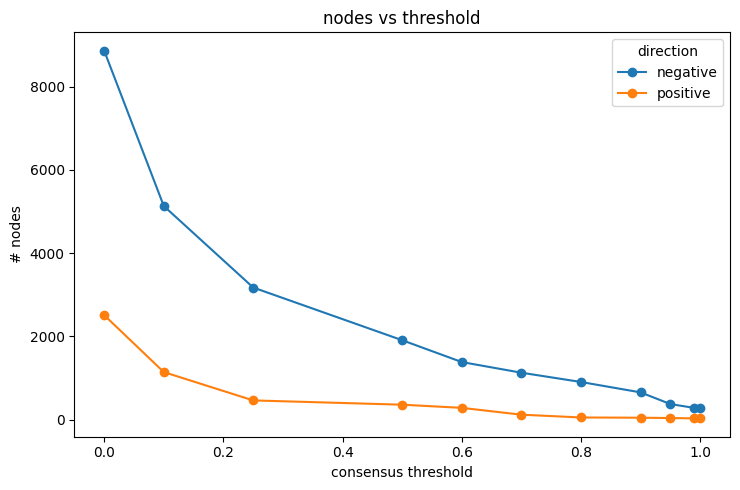

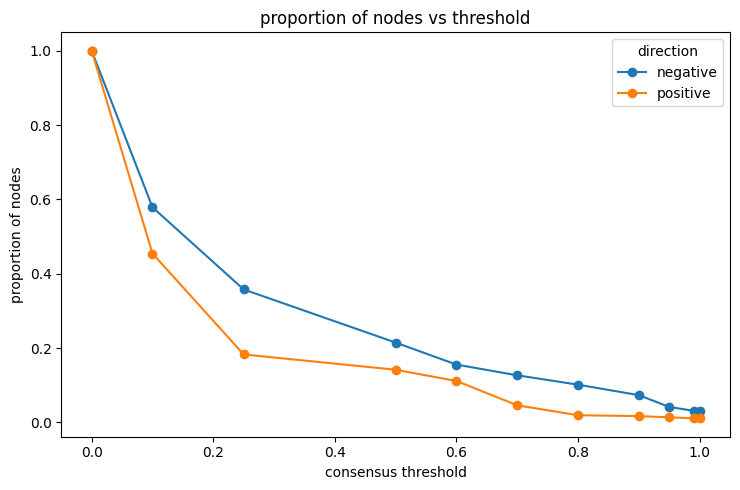

,label,direction,threshold,num_nodes,num_edges,prop_nodes
0,sample,negative,0.00,8866,40654,1.000000
1,sample,positive,0.00,2508,3599,1.000000
2,sample,negative,0.10,5132,16066,0.578841
3,sample,positive,0.10,1140,1530,0.454545
4,sample,negative,0.25,3173,6944,0.357884
5,sample,positive,0.25,459,544,0.183014
6,sample,negative,0.50,1906,3041,0.214979
7,sample,positive,0.50,356,402,0.141946
8,sample,negative,0.60,1381,1890,0.155764
9,sample,positive,0.60,280,313,0.111643


In [ ]:
# look at the number and proportion of nodes in common across the rewired networks
cons_stats = splitpea.analyze_consensus_threshold(
    neg_path='consensus_network_neg.pickle',
    pos_path='consensus_network_pos.pickle',
    save_pdf_prefix='ucs_consensus_sum'
)
cons_stats

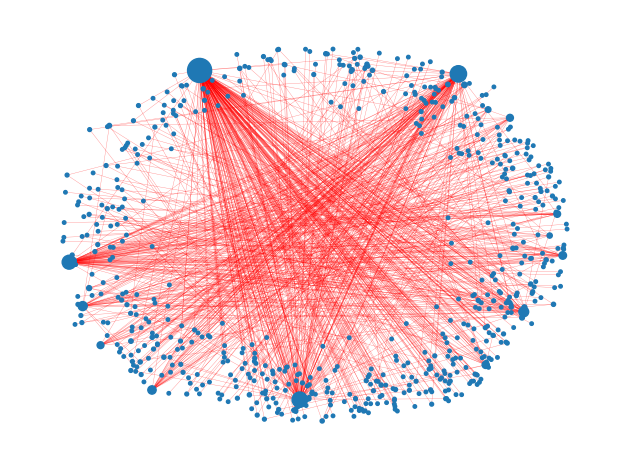

Generated outputs:
  PDF → ucs_cons_loss_90.pdf
  Gephi TSV → ucs_cons_loss_90.csv


In [27]:
# plot the resulting consensus network
# for rewired edges that are lost in 90% of patients
splitpea.plot(
    rewired_net = 'consensus_network_neg.pickle',
    threshold = 0.9,
    lcc = True,
    pdf_path = 'ucs_cons_loss_90.pdf',
    gephi_path = 'ucs_cons_loss_90.csv'
)

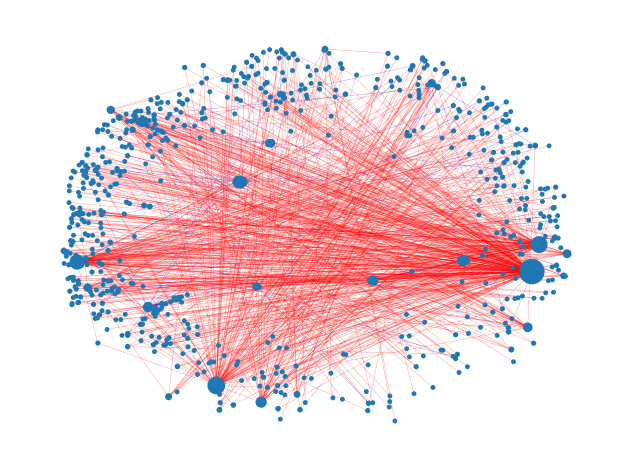

Generated outputs:
  PDF → ucs_cons_tot_90.pdf


In [26]:
# plot the gain and loss edges for the consensus network
# where edges are present in 90% of samples
# join both of the loss and gain networks
cons_tot = nx.compose(cons_neg, cons_pos)

splitpea.plot(
    rewired_net = cons_tot,
    threshold = 0.90,
    lcc = True,
    pdf_path = 'ucs_cons_tot_90.pdf'
)